# Time Series forecasting of Corporación Favorita


This project is based on a Kaggle challenge to forecast the sales of Corporación Favorita, an Ecuadorian-based grocery retailer. The challenge is in: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/
The tutorial for time series in Kaggle was one of the main inspirations for this work: https://www.kaggle.com/learn/time-series

# Table of contents

* [Importing libraries and data](#import)

* [Understanding the data - EDA](#understanding)
    * [Time series analysis](#timeseries)
        * [Time series trend](#trend)
        * [Lag features](#lag)
        * [Weekly Seasonality](#seasonality)
    * [Data analysis](#data)
        * [Family of products](#family)
        * [Stores](#stores)
        * [On promotion](#promo)
        * [Oil](#oil)
* [Model](#model)
    * [Hybrid model test: Linear regression + XGBoost](#hybrid)
    * [Prediction with the hybrid model by recursion](#recursion)
    * [Direct prediction with the hybrid model](#direct)

## Importing libraries and data <a class="anchor" id="import"></a>

In [95]:
## Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 15
pd.options.display.max_columns = 85

from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import DeterministicProcess

In [96]:
df_s = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_chal = pd.concat([df_s,df_test])
df_chal.set_index("id",inplace=True)
df_stores = pd.read_csv("stores.csv")

## Understanding the data - EDA <a class="anchor" id="understanding"></a>

When facing a prediction problem, one of the first things one should do is asking: what factors would I need to know in order to make a decent prediction?
For this particular problem: If I would want to predict sales for a specific day, what would be the factors I would consider? Brainstorming and a quick look in the Internet gave me these:
- Dates:
    - Weekend
    - Holidays and special days
    - Christmas and days with special offers (e.g. Black Friday)
- Location of shops:
    - Big cities, small cities or rural areas
- Economy:
    - Crisis, either local (city, county, country) or global
    - Oil prices
- Catastrophes:
    - Earthquakes, etc
- Paydays:
    - Public sector salaries are paid the 15th and last day of the month 
    
Later, when making the prediction, we will see that some of these are very useful (shop data, weekends).

For this problem, I built a hybrid model with linear regression for the lag and trend features and then I applied XGBoost on the residuals for the other features. For the predictions, I tried 2 methods: recursion and direct prediction of a time series. The recursion had best results, with a score of 1.18 - which is not bad, considering the top score is 0.377. 

The features of our training data, as explained by Kaggle, are:
- **store_nbr** identifies the store at which the products are sold.
- **family** identifies the type of product sold.
- **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

First, let's have a look at our data to get a general idea.

In [97]:
print("----------Top-5- Record----------")
print(df_chal.head(5))
print("----------Last-5- Record----------")
print(df_chal.tail(5))
print("-----------Information-----------")
print(df_chal.info())
print("-----------Data Types-----------")
print(df_chal.dtypes)
print("----------Missing value-----------")
print(df_chal.isnull().sum())
print("----------Null value-----------")
print(df_chal.isna().sum())
print("----------Shape of Data----------")
print(df_chal.shape)

----------Top-5- Record----------
          date  store_nbr      family  sales  onpromotion
id                                                       
0   2013-01-01          1  AUTOMOTIVE    0.0            0
1   2013-01-01          1   BABY CARE    0.0            0
2   2013-01-01          1      BEAUTY    0.0            0
3   2013-01-01          1   BEVERAGES    0.0            0
4   2013-01-01          1       BOOKS    0.0            0
----------Last-5- Record----------
               date  store_nbr                      family  sales  onpromotion
id                                                                            
3029395  2017-08-31          9                     POULTRY    NaN            1
3029396  2017-08-31          9              PREPARED FOODS    NaN            0
3029397  2017-08-31          9                     PRODUCE    NaN            1
3029398  2017-08-31          9  SCHOOL AND OFFICE SUPPLIES    NaN            9
3029399  2017-08-31          9                     

In [98]:
for column in df_chal:
    unique_values = df_chal[column].unique()
    number_values = len(unique_values)
    if number_values <= 40: # Only print if unique values are less than 11
        print(f"The {column} feature has {number_values} values, which are:{unique_values}")
    else :
        print(f"The {column} feature has {number_values} values")

The date feature has 1700 values
The store_nbr feature has 54 values
The family feature has 33 values, which are:['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
The sales feature has 379611 values
The onpromotion feature has 367 values


There are:
- A total of 1684 days of data
- 54 different shops
- 33 different kinds of products 

In order to study seasonality, trends and other aspects of a time series, we need to expand the training data with more date features:

In [99]:
df_chal['date'] = pd.to_datetime(df_chal['date'])
## Add different date features 
df_chal["Year"] = df_chal['date'].dt.year
df_chal["DayofYear"] = df_chal['date'].dt.dayofyear
df_chal["Month"] = df_chal['date'].dt.month
df_chal["DayofMonth"] = df_chal['date'].dt.day
df_chal["Week"] = df_chal['date'].dt.isocalendar().week.astype(np.int16) # Week number for each month
df_chal["DayofWeek"] = df_chal['date'].dt.dayofweek

## Create column "Year-Month" by combining the month and the year
df_chal["Year-Month"] = df_chal["Year"].astype(str) + '-' + df_chal["Month"].astype(str).str.zfill(2)
## Convert "Year-Month" to time dummy feature "Month number"
df_chal["MonthNumber"] = pd.factorize(df_chal["Year-Month"])[0]
## Time dummy feature "Day number"
df_chal["DayNumber"] = pd.factorize(df_chal["date"])[0]

In [100]:
## Downcast data type to reduce memory used by dataframe
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

df_chal = downcast_dtypes(df_chal)
print(df_chal.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3029400 entries, 0 to 3029399
Data columns (total 14 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int16         
 2   family       object        
 3   sales        float32       
 4   onpromotion  int16         
 5   Year         int16         
 6   DayofYear    int16         
 7   Month        int16         
 8   DayofMonth   int16         
 9   Week         int16         
 10  DayofWeek    int16         
 11  Year-Month   object        
 12  MonthNumber  int16         
 13  DayNumber    int16         
dtypes: datetime64[ns](1), float32(1), int16(10), object(2)
memory usage: 161.8+ MB
None


In a time series, we generally study trends, seasonality and cycles, which can greatly improve predictions.

### Time series analysis <a class="anchor" id="timeseries"></a>

#### Time series trend <a class="anchor" id="trend"></a>

We want to see if there is a general trend for the time series. Monthly total sales shows a consistent increase in sales, although the result does not look linear:

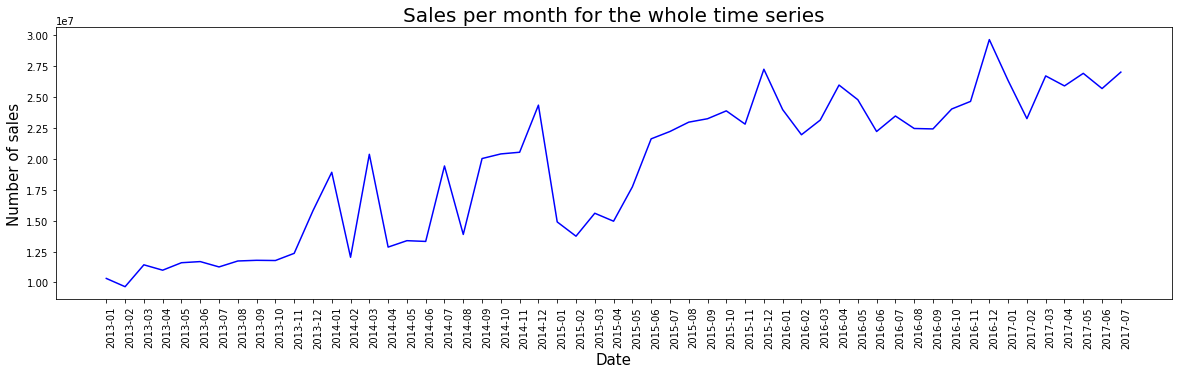

In [101]:
## Group the data by Year/Month
by_nmonth= df_chal.groupby("Year-Month")[["sales"]].sum()
## Plot
fig,ax = plt.subplots(figsize=(20,5))
ax.plot(by_nmonth.index[:-1],by_nmonth["sales"][:-1], 'b', label="Total sales") # Without last date as we have only half the data
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
ax.set_title(f"Sales per month for the whole time series",fontsize=20)
ax.set_xlabel("Date",fontsize=15)
ax.set_ylabel("Number of sales",fontsize=15)

del by_nmonth

Let's look at the total daily sales:

Text(0, 0.5, 'Sales')

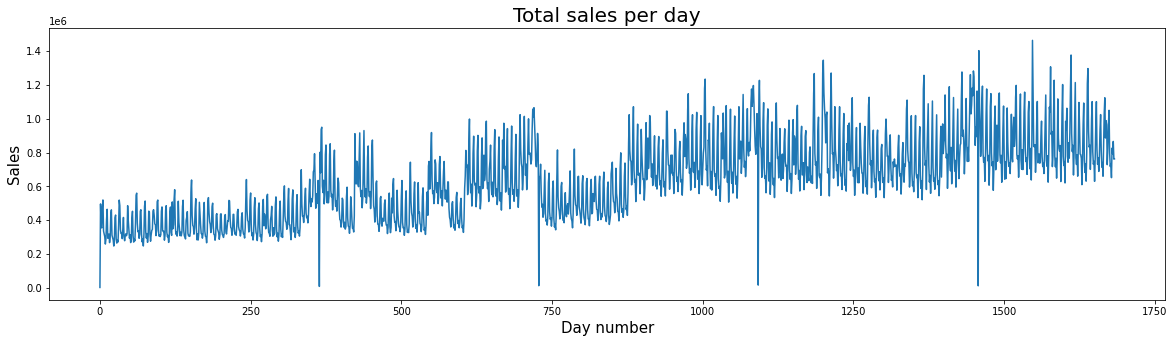

In [102]:
## Group the data by day
total_sales= df_chal.groupby("DayNumber")[["sales"]].sum()
## Plot
fig,ax = plt.subplots(figsize=(20,5))
ax.plot(total_sales.index[:1684],total_sales["sales"][:1684], label="Total sales") # Without last date as we have only half the data
ax.set_title(f"Total sales per day",fontsize=20)
ax.set_xlabel("Day number",fontsize=15)
ax.set_ylabel("Sales",fontsize=15)

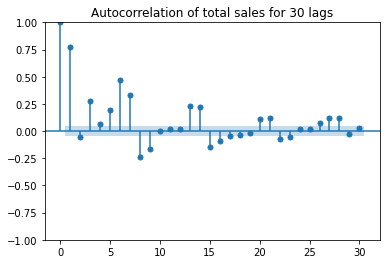

In [103]:
from statsmodels.graphics.tsaplots import plot_pacf
_ = plot_pacf(total_sales["sales"], lags=30, method="ywm",title="Autocorrelation of total sales for 30 lags")

The total sales per day is an important piece of information, so I will add it to our main dataframe:

In [104]:
## Adding "TotalSalesDay" column (total sales of the day) to df_sales dataframe
tot = np.zeros(df_chal.shape[0])
for i in np.arange(0,1700):
    tot[i*1782:(i+1)*1782] = np.full(
  shape=1782,
  fill_value=total_sales["sales"].iloc[i],
  dtype=np.int32
    )

df_chal["TotSalesDay"] = tot

As the trend is not so clear, let's look if by deseasonalizing the time series with the rolling method the trend becomes more obvious:

<AxesSubplot:title={'center':'Sales - 365-Day Moving Average'}, xlabel='DayNumber'>

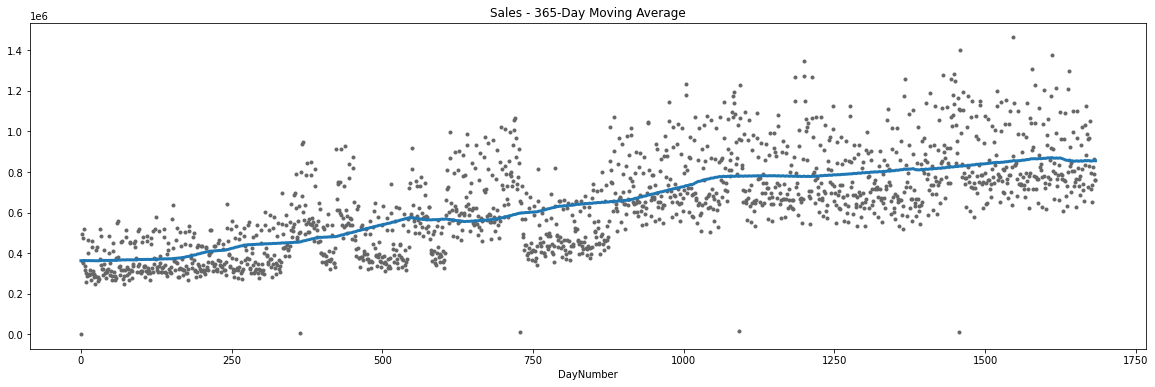

In [105]:
moving_avg = total_sales["sales"][:1684].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=180,  
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = total_sales["sales"][:1684].plot(style=".", color="0.4")
moving_avg.plot(
    ax=ax, linewidth=3, title="Sales - 365-Day Moving Average", legend=False,figsize=(20,6))

The trend looks like a very smooth exponential, that could be represented by a squared or cubic function. Using DeterministicProcess we can see what the result might look like for a squared function:

Trend features tail:
            const   trend  trend_squared
DayNumber                              
1679         1.0  1680.0      2822400.0
1680         1.0  1681.0      2825761.0
1681         1.0  1682.0      2829124.0
1682         1.0  1683.0      2832489.0
1683         1.0  1684.0      2835856.0


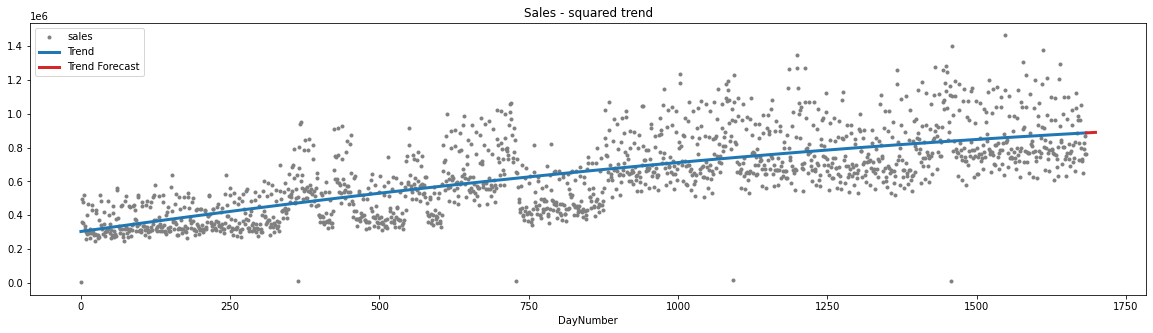

In [106]:
dp = DeterministicProcess(
    index=total_sales[:1684].index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# "in_sample" creates features for the dates given in the "index" argument
X_in = dp.in_sample()
# "out_sample" featues for the prediction
X_out = dp.out_of_sample(steps=16)

print("Trend features tail:\n",X_in.tail())

y = total_sales["sales"][:1684]  # the target

# The intercept is the same as the "const" feature from DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X_in, y)

y_pred = pd.Series(model.predict(X_in), index=X_in.index)

## Trend plot + prediction
y_fore = pd.Series(model.predict(X_out), index=X_out.index)
y_fore.tail()
ax = total_sales["sales"][:1684].plot(style=".", color="0.5", title="Sales - squared trend",figsize=(20,5))
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

#### Lag features <a class="anchor" id="lag"></a>

In order to study the cycles than can affect the time series, lag features can be very helpful. We have to consider that each day includes 1782 entries (54 shops * 33 families of products)

In [107]:
df_chal["sales_Lag+1"] = df_chal["sales"].shift(1782).fillna(0)

Correlation of the lags for 2 weeks after and 2 weeks before with "sales": 

Text(0, 0.5, 'Correlation')

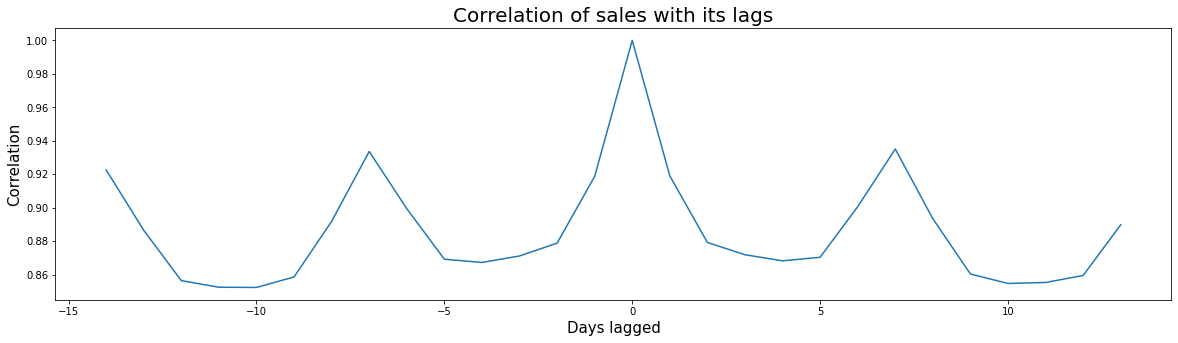

In [108]:
lag_c = []
for l in np.arange(-14,14):
    lag = df_chal["sales"].shift(1782*l).fillna(0)
    c = df_chal["sales"].corr(lag)
    lag_c.append(c)
    
fig,ax = plt.subplots(figsize=(20,5))
ax.plot(np.arange(-14,14),lag_c)
ax.set_title(f"Correlation of sales with its lags",fontsize=20)
ax.set_xlabel("Days lagged",fontsize=15)
ax.set_ylabel("Correlation",fontsize=15)

There is a high correlation between "sales" and it lags. Particularly:
- With the day before and the day after
- Each week after
- Each week before

#### Weekly seasonality <a class="anchor" id="seasonality"></a>

We want to see if there is a seasonality (this is, a pattern related with a time period; in this case, weeks).

In [109]:
## Group the data to study sales for day of the week
by_week = df_chal.groupby(["Year","Week","DayofWeek"])[["sales"]].sum().reset_index()
## Group the data to get the DayofWeek sales average per year
by_week_avg = by_week.groupby(["Year","DayofWeek"])["sales"].mean().reset_index()

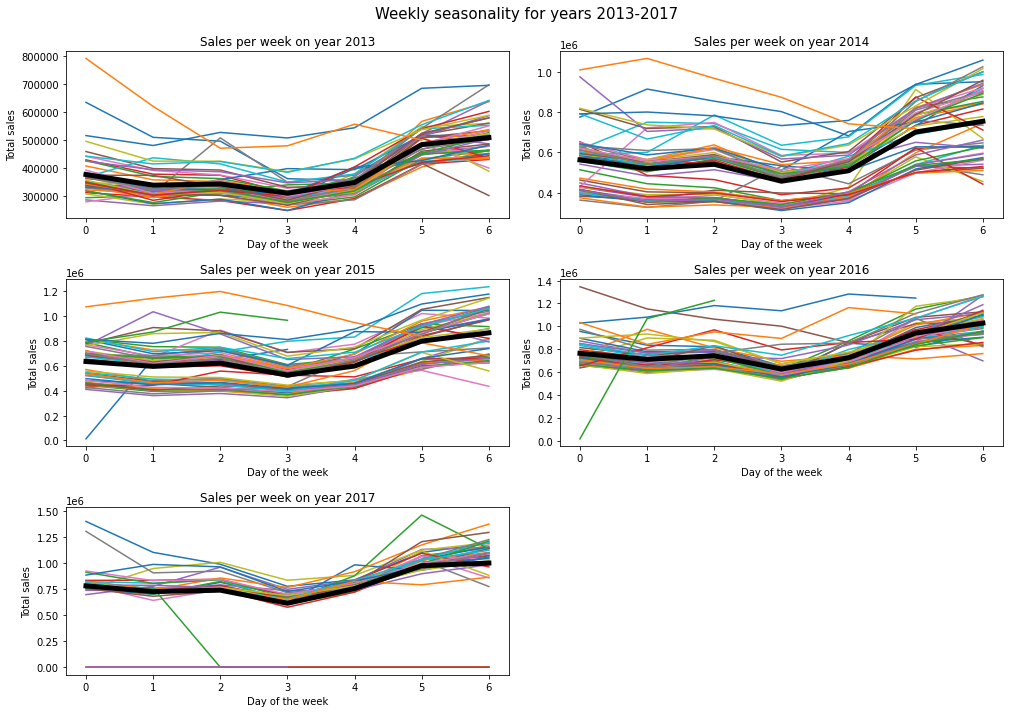

In [110]:
fig,ax = plt.subplots(3,2,figsize=(14,10))
fig.delaxes(ax[2,1])
fig.suptitle("Weekly seasonality for years 2013-2017", fontsize=15)
fig.tight_layout(pad=2, w_pad=2, h_pad=4)
a = ((0,0),(0,1),(1,0),(1,1),(2,0))
i = 0
for y in np.arange(2013,2018):
    ax[a[i]].set_title(f"Sales per week on year {y}",fontsize=12)
    ax[a[i]].set_xlabel("Day of the week",fontsize=10)
    ax[a[i]].set_ylabel("Total sales",fontsize=10)
    for w in df_chal["Week"].unique():
        ## Plot each week for the year "y"
        ax[a[i]].plot(np.arange(0,len(by_week["sales"].loc[(by_week["Year"] == y) & (by_week["Week"] == w)])),
                         by_week["sales"].loc[(by_week["Year"] == y) & (by_week["Week"] == w)])
    ## Plot the mean for year "y"
    ax[a[i]].plot(np.arange(0,len(by_week_avg.loc[by_week_avg["Year"] == y])),
                         by_week_avg.loc[by_week_avg["Year"] == y]["sales"],color="black",linewidth=5)
    i += 1

The previous plots show there is a weekly trend, with the black line being the average: there is a zig zag during weekdays (from Monday to Tueday goes down, then up, then down, then up, with finally sales on Monday and Friday being very similar) and a big increase on Saturdays and then even more on Sundays (which are the days, generally, with most sales). 

By one-hot encoding days of the week, we will get the weekly seasonal indicators by the model, which shall improve predictions.

### Data analysis <a class="anchor" id="data"></a>

#### Family of products <a class="anchor" id="family"></a>

A good feature candidate is the total of sales for each product in each day (this is, adding all sales from all shops), and then lagging it for one or more days in order to predict future sales. Let's first plot each of these totals:

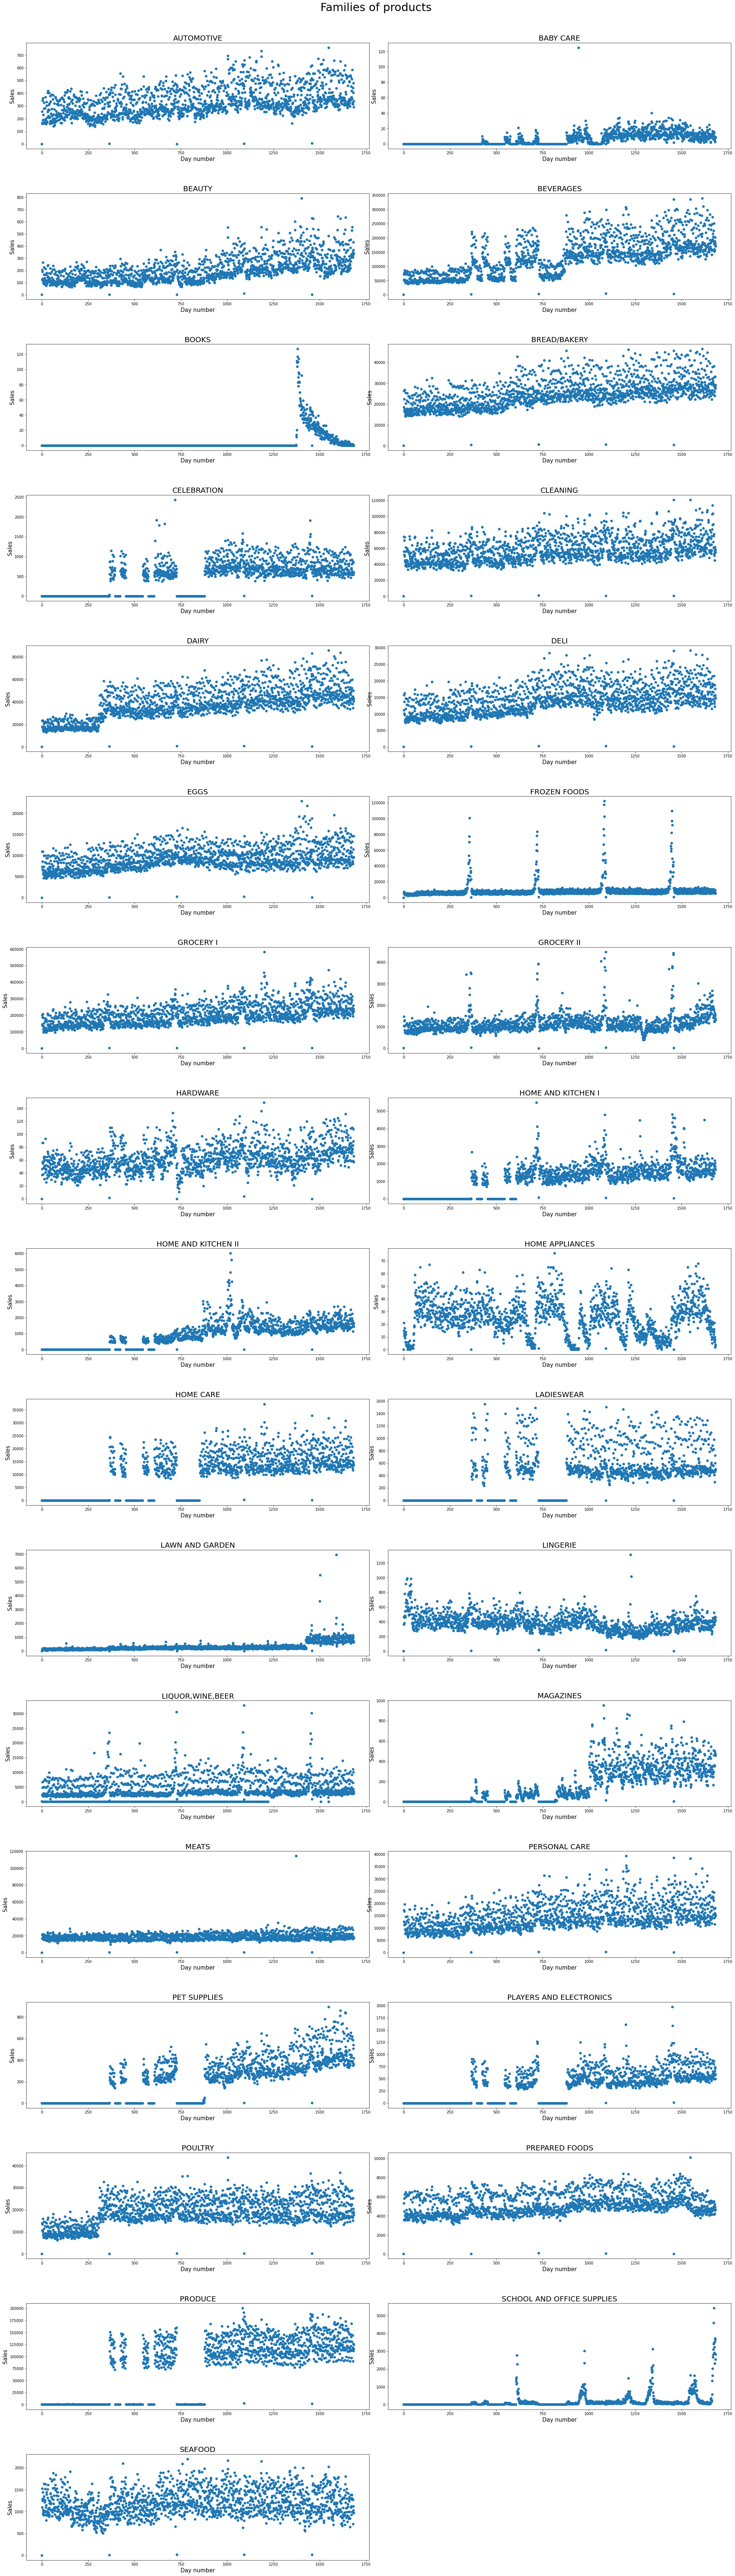

In [111]:
## Group families of product sales by day number of the time series
family_sales= df_chal.groupby(["family","DayNumber"])[["sales"]].sum().reset_index()

fig, ax = plt.subplots(17, 2, figsize=(30,100))
fig.suptitle("Families of products", fontsize=30)
#fig.tight_layout(pad = 5.)
fig.delaxes(ax[16,1])
fig.tight_layout(pad=11, w_pad=2, h_pad=10)
c = 0
for i,label in enumerate(family_sales["family"].unique()):
    ax[c,i%2].scatter(np.arange(0,1684),family_sales.loc[(family_sales["family"] == label) &
                                                         (family_sales["DayNumber"] < 1684),"sales"])
    ax[c,i%2].set_title(f"{label}",fontsize=20)
    ax[c,i%2].set_xlabel("Day number",fontsize=15)
    ax[c,i%2].set_ylabel(f"Sales",fontsize=15)
    if i%2 != 0:
        c = c + 1

By uncommenting the cell below, we can see the partial autocorrelation for all these values and how the lag of one day is highly correlated for all of them.

In [112]:
#from statsmodels.graphics.tsaplots import plot_pacf
## Partial autocorrelation for each family of products
#for family in family_sales["family"].unique():
#    _ = plot_pacf(family_sales["sales"].loc[family_sales["family"] == family], lags=30, method="ywm",title=family)

#### Stores <a class="anchor" id="stores"></a>

The Kaggle data included a table with shops medatada: city, state, type, and cluster. Cluster groups similar stores, with the criteria for this is not explained. As we will see, type and cluster are good predictors for our algorithm.

First let's have a look at the store data:

In [113]:
for column in df_stores:
    unique_values = df_stores[column].unique()
    number_values = len(unique_values)
    if number_values <= 40: # Only print if unique values are less than 11
        print(f"The {column} feature has {number_values} values, which are:{unique_values}")
    else :
        print(f"The {column} feature has {number_values} values")

The store_nbr feature has 54 values
The city feature has 22 values, which are:['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']
The state feature has 16 values, which are:['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']
The type feature has 5 values, which are:['D' 'B' 'C' 'E' 'A']
The cluster feature has 17 values, which are:[13  8  9  4  6 15  7  3 12 16  1 10  2  5 11 14 17]


When tested on the algorithm the features "store_type" and "store_cluster" improve the prediction, so I will add them to our dataframe.

#### On promotion <a class="anchor" id="promo"></a>

Let's see if "onpromotion" can help, by study its correlation with "sales" and seeing if it would also be useful as a lag feature:

Text(0, 0.5, 'Correlation')

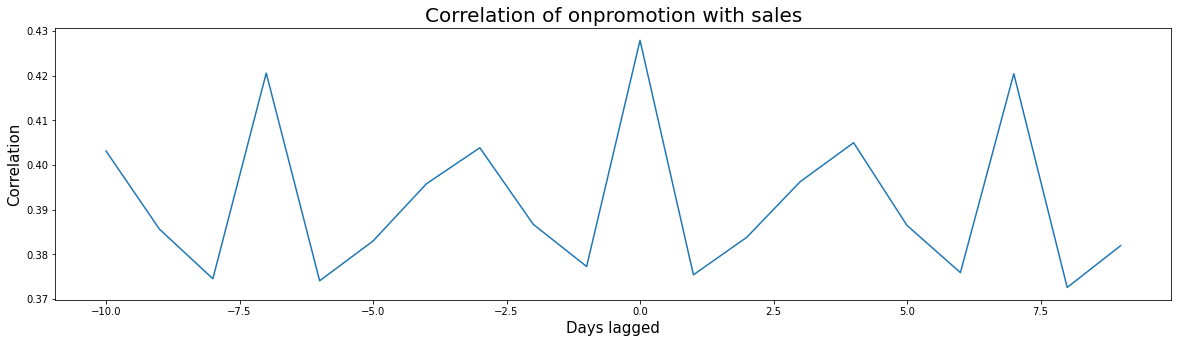

In [114]:
prom_lag = []
for l in np.arange(-1782*10,1782*10,1782):
    lag = df_chal["onpromotion"].shift(l).fillna(0)
    prom_lag.append(df_chal["sales"].corr(lag))

fig,ax = plt.subplots(figsize=(20,5))
ax.plot(np.arange(-10,10),prom_lag)
ax.set_title(f"Correlation of onpromotion with sales",fontsize=20)
ax.set_xlabel("Days lagged",fontsize=15)
ax.set_ylabel("Correlation",fontsize=15)

Best correlation is with the same day and, if we study autocorrelation, we see lags do not give much information: 

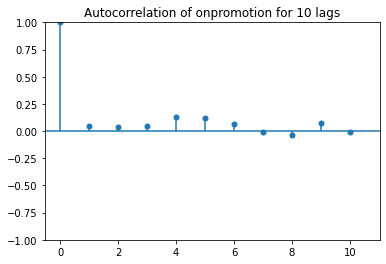

In [115]:
_ = plot_pacf(df_chal.onpromotion, lags=10, method="ywm",title="Autocorrelation of onpromotion for 10 lags")

#### Oil <a class="anchor" id="oil"></a>

Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [116]:
df_oil = pd.read_csv("oil.csv")
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [117]:
## Adding missing dates to df_oil, and filling their "dcoilwtico" value with the existing one
df_oil["date"] = pd.to_datetime(df_oil["date"])
df_oil = df_oil.set_index("date").asfreq('D').reset_index().fillna(method='ffill')
df_oil.loc[0,"dcoilwtico"] = df_oil.loc[1,"dcoilwtico"]
df_oil.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12


In [118]:
## Remove the day 25 of December for every year (which are not included in df_sales)
df_oil.drop(df_oil[df_oil["date"] == "2013-12-25"].index, inplace=True)
df_oil.drop(df_oil[df_oil["date"] == "2014-12-25"].index, inplace=True)
df_oil.drop(df_oil[df_oil["date"] == "2015-12-25"].index, inplace=True)
df_oil.drop(df_oil[df_oil["date"] == "2016-12-25"].index, inplace=True)
df_oil = df_oil.reset_index().drop("index",axis=1)

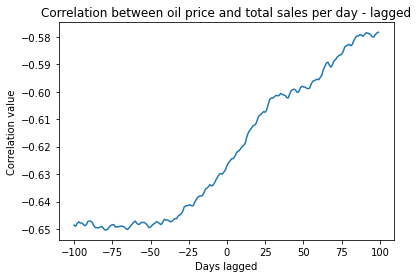

In [119]:
cor = []
total_lag = range(-100,100)
for lag in total_lag:
    v_oil = df_oil["dcoilwtico"][:1684].shift(lag)
    cor.append(v_oil.corr(total_sales.loc[0:1683,"sales"]))
fig = plt.figure()
ax = plt.axes()
ax.plot(total_lag, cor);
plt.title("Correlation between oil price and total sales per day - lagged")
plt.xlabel("Days lagged")
plt.ylabel("Correlation value");

There is a negative correlation between the oil price and the total sales per day, with highest correlation from lag -50 (although at day zero we have a value of around -0.62, so is not a big difference).
Therefore, the oil price should be a good predictor for the total sales per day but, when used with the algorithm, it lessens the performance - so there might be some correlation with other features.

## Model <a class="anchor" id="model"></a>

First we prepare all data (including test data), and slice the dataframe from day 1092 onwards, which corresponds to all year 2016 and 2017. This is in order to reduce the memory consumption, as my computer was not able to deal with the full dataset. 

### Preparing feature and target arrays

In [120]:
# Function to create dummies from a feature: one-hot encodes it and removes the original column
def dummies(df,label):
    df_temp = pd.get_dummies(df[label], prefix=label)
    df = pd.concat([df, df_temp], axis=1)     # Merge df with new dummy features
    
    return df

## Downcast data type to reduce memory used by dataframe
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [121]:
## Choose day from 0 to 1700 (the closer to 1700, the less likely we run out of memory)----------------------------------------------------------------------------------------------------
from_day = 1092 #Day 1092 -> From 2016 onwards
## ---------------------------------------------------------------------------------------------------------------------------------

## Loading all data
df_s = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_chal = pd.concat([df_s,df_test]) # Includes all training and test data
df_chal.set_index("id",inplace=True)
df_stores = pd.read_csv("stores.csv")

df_chal['date'] = pd.to_datetime(df_chal['date'])
df_chal["DayofWeek"] = df_chal['date'].dt.dayofweek

## Time dummy feature "Day number"
df_chal["DayNumber"] = pd.factorize(df_chal["date"])[0]
df_chal.drop("date",inplace=True,axis=1)

## Group the data by day
total_csales= df_chal.groupby("DayNumber")[["sales"]].sum()

## Adding "TotalSalesDay" column (total sales of the day) to df_chal dataframe
df_chal["TotSalesDay"] = np.repeat(total_csales["sales"],1782).to_list()
## "TotalSalesDay" with 1 and 21 days lag
df_chal["TotSalesDay_lag1"] = df_chal["TotSalesDay"].shift(1782)
df_chal["TotSalesDay_lag21"] = df_chal["TotSalesDay"].shift(21*1782)

## Adding "sales" with 1 and 21 days lag
df_chal["sales_lag1"] = df_chal["sales"].shift(1782)
df_chal["sales_lag21"] = df_chal["sales"].shift(21*1782)
    
## Adding 1 day lag for total sales per day for family product
family_csales= df_chal.groupby(["family","DayNumber"])[["sales"]].sum().reset_index()
for label in family_csales["family"].unique(): # loop over each family of products: AUTOMOTIVE, BABY CARE, etc
    # Array with 1 if a row includes "label", 0 if not 
    tot1 = np.where(df_chal["family"].values == label, 1, 0)
    # Array with the total sales per day of "label", each of them repeated 1782 times (number of total entries per day)
    tot2 = np.repeat(family_csales["sales"].loc[family_csales["family"] == label],1782)
    # Lag feature for the product family
    df_chal[label+"_lag1"] = np.multiply(tot1,tot2).shift(1782).fillna(0).tolist()
    
## Adding trend
dp = DeterministicProcess(index=total_csales.index, order=2, drop=True)
X_trend = dp.in_sample()
for col in X_trend: # incorporate trend columns in our df_chal dataframe
    df_chal[col] = np.repeat(X_trend[col],1782).reset_index(drop=True)

## We slice df_chal from "from_day" onwards
df_chal = df_chal.loc[df_chal["DayNumber"] >= from_day]

## Adding feature "store_type" to df_chal
df_chal["store_type"] = df_chal["store_nbr"]
for l in ['A', 'B', 'C', 'D', 'E']:
    nlist = df_stores["store_nbr"].loc[df_stores["type"] == l].to_list()
    df_chal.loc[df_chal["store_type"].isin(nlist),"store_type"] = l
    
## Adding featue "store_cluster" to df_chal
df_chal["store_cluster"] = df_chal["store_nbr"]
for n in df_stores["cluster"].unique():
    nlist = df_stores["store_nbr"].loc[df_stores["cluster"] == n].to_list()
    df_chal.loc[df_chal["store_cluster"].isin(nlist),"store_cluster"] = str(n)

## Adding dummies for categorical features
for col in ["store_nbr","family","DayofWeek","store_type","store_cluster"]:
    df_chal = dummies(df_chal,col)
    if col != "family":
        df_chal.drop(col,inplace=True,axis=1)

df_chal = downcast_dtypes(df_chal)
for c in [c for c in df_chal if df_chal[c].dtype == "float32"]:
    if max(df_chal[c]) < 32000. :
        df_chal[c] = df_chal[c].astype(np.float16)

Preparing the feature matrix and target array:

In [122]:
## X_cont: continuous features---------------------------------------------------------------------------------------------
X_contcol =  ['TotSalesDay_lag1','TotSalesDay_lag21',
              'sales_lag1','sales_lag21','trend','trend_squared',
             'onpromotion','AUTOMOTIVE_lag1', 'BABY CARE_lag1',
       'BEAUTY_lag1', 'BEVERAGES_lag1', 'BOOKS_lag1', 'BREAD/BAKERY_lag1',
       'CELEBRATION_lag1', 'CLEANING_lag1', 'DAIRY_lag1', 'DELI_lag1',
       'EGGS_lag1', 'FROZEN FOODS_lag1', 'GROCERY I_lag1', 'GROCERY II_lag1',
       'HARDWARE_lag1', 'HOME AND KITCHEN I_lag1', 'HOME AND KITCHEN II_lag1',
       'HOME APPLIANCES_lag1', 'HOME CARE_lag1', 'LADIESWEAR_lag1',
       'LAWN AND GARDEN_lag1', 'LINGERIE_lag1', 'LIQUOR,WINE,BEER_lag1',
       'MAGAZINES_lag1', 'MEATS_lag1', 'PERSONAL CARE_lag1',
       'PET SUPPLIES_lag1', 'PLAYERS AND ELECTRONICS_lag1', 'POULTRY_lag1',
       'PREPARED FOODS_lag1', 'PRODUCE_lag1',
       'SCHOOL AND OFFICE SUPPLIES_lag1', 'SEAFOOD_lag1']

X_cont = df_chal.loc[(df_chal["DayNumber"] >= from_day) & (df_chal["DayNumber"] < 1684),X_contcol].copy()
##-------------------------------------------------------------------------------------------------------------------------------------

##X_cat: categorical features-------------------------------------------------------------------------------------------------------------   
X_catcol = []
## List with all categorical columns
for cat in ["store_nbr","family","DayofWeek","store_type","store_cluster"]:
    X_catcol.append([col for col in df_chal if col.startswith(cat)])
## Flatten the list
X_catcol = list(np.concatenate(X_catcol).flat)

X_cat = df_chal.loc[(df_chal["DayNumber"] >= from_day) & (df_chal["DayNumber"] < 1684),X_catcol]
X_cat.drop("family",inplace=True,axis=1)
##-------------------------------------------------------------------------------------------------------------------------------

# Target array
y = np.array(df_chal.loc[(df_chal["DayNumber"] >= from_day) & (df_chal["DayNumber"] < 1684),"sales"])

lin_f = ['TotSalesDay_lag1', 'sales_lag1','trend','trend_squared'] # Linear regression features for the hybrid model
X_tot = pd.concat([X_cont,X_cat],axis=1)
X_xgb = X_tot.copy()
X_lin = pd.concat([X_xgb.pop(x) for x in lin_f], axis=1)

print(f"X_cont:",X_cont.shape,"X_cat:",X_cat.shape,"X_tot:",X_tot.shape, "X_lin:",X_lin.shape,"X_xgb:",X_xgb.shape)

X_cont: (1054944, 40) X_cat: (1054944, 116) X_tot: (1054944, 156) X_lin: (1054944, 4) X_xgb: (1054944, 152)


### Linear regression

This is a quick implementation of linear regression to be used as a benchmark.

In [123]:
## Normalization of features
scaler = preprocessing.StandardScaler().fit(X_tot)
X_tot = scaler.transform(X_tot)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tot, y, test_size=0.3, random_state=17)

print(f"X has dimension {X_tot.shape}\ny has dimesion {y.shape}")

# Train the model
lr = LinearRegression()
lr.fit(X_train, y_train)

yhat_train_lr = lr.predict(X_train)
yhat_test_lr = lr.predict(X_test)

## Remove negative values from prediction
yhat_train_lr = yhat_train_lr.clip(min=0)
yhat_test_lr = yhat_test_lr.clip(min=0)

train_error_lr = np.sqrt(sum((y_train-yhat_train_lr)**2/len(y_train)))
test_error_lr = np.sqrt(sum((y_test-yhat_test_lr)**2/len(y_test)))
print(f"Training set RMSE error: {train_error_lr:.4f},Test set RSME error:{test_error_lr:.4f}")

X has dimension (1054944, 156)
y has dimesion (1054944,)
Training set RMSE error: 403.5015,Test set RSME error:468.3880


### Hybrid model test: Linear regression + XGBoost <a class="anchor" id="hybrid"></a>

We will run linear regression for the main lag features and the trend ones (as XGBoost can not predict in a different range than the values of its features). Then, we will train and predict with XGBoost on residuals.

In [124]:
X_tot = pd.concat([X_cont,X_cat],axis=1)
scaler = preprocessing.StandardScaler().fit(X_tot)
X_tot = scaler.transform(X_tot)

X_lin = X_tot[:,:len(lin_f)]
X_xgb = X_tot[:,len(lin_f):]

Xlin_train, Xlin_test, ylin_train, ylin_test = train_test_split(X_lin, y, test_size=0.3, random_state=17)
Xxgb_train, Xxgb_test, yxgb_train, yxgb_test = train_test_split(X_xgb, y, test_size=0.3, random_state=17)

print(X_lin.shape,X_xgb.shape)

(1054944, 4) (1054944, 152)


In [125]:
# 1. Train and predict with first model
lr_pred = LinearRegression()
lr_pred.fit(Xlin_train, ylin_train)
y_pred_1 = lr_pred.predict(Xlin_train)
y_pred_1 = y_pred_1.clip(min=0)
y_pred_1t = lr_pred.predict(Xlin_test)
y_pred_1t = y_pred_1t.clip(min=0)
train_e_lr = np.sqrt(sum((y_pred_1-ylin_train)**2/len(ylin_train)))
test_e_lr = np.sqrt(sum((y_pred_1t-ylin_test)**2/len(ylin_test)))
print(f"LR: Training set RMSE error: {train_e_lr:.4f},Test set RSME error:{test_e_lr:.4f}")

# 2. Train and predict with second model on residuals
xg_pred = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_pred.fit(Xxgb_train, yxgb_train - y_pred_1)
y_pred_2 = xg_pred.predict(Xxgb_train)
y_pred_2 = y_pred_2.clip(min=0)
y_pred = y_pred_1 + y_pred_2
y_pred_2t = xg_pred.predict(Xxgb_test)
y_pred_2t = y_pred_2t.clip(min=0)
y_pred_t = y_pred_1t + y_pred_2t
train_e_xgb = np.sqrt(sum((y_pred-yxgb_train)**2/len(yxgb_train)))
test_e_xgb = np.sqrt(sum((y_pred_t-yxgb_test)**2/len(yxgb_test)))
print(f"XGBoost: Training set RMSE error: {train_e_xgb:.4f},Test set RSME error:{test_e_xgb:.4f}")

LR: Training set RMSE error: 418.2698,Test set RSME error:483.4290
XGBoost: Training set RMSE error: 408.2374,Test set RSME error:478.0823


###  Prediction with the hybrid model by recursion <a class="anchor" id="recursion"></a>

Here we will predict sales for just the first day and, with that data, calculate the lags for the following day. By iterating this process for all days we want (15, in this case), we get our predictions.

This method has the issue of acumulating error as we go by, although here we are not going through many days.

In [126]:
# 1. Train and predict with first model
scaler = preprocessing.StandardScaler().fit(X_lin)
X_lin = scaler.transform(X_lin)
lr_pred = LinearRegression()
lr_pred.fit(X_lin, y)
y_pred_1 = lr_pred.predict(X_lin)
y_pred_1 = y_pred_1.clip(min=0)

# 2. Train and predict with second model on residuals
scaler = preprocessing.StandardScaler().fit(X_xgb)
X_xgb = scaler.transform(X_xgb)
xg_pred = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_pred.fit(X_xgb, y - y_pred_1)
y_pred_2 = xg_pred.predict(X_xgb)
y_pred_2 = y_pred_2.clip(min=0)

# 3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2

print("The RMSE error with the current training set is of",np.sqrt(sum((y-y_pred)**2/len(y))))

The RMSE error with the current training set is of 428.53276011842655


In [127]:
## Iteration to get predictions for each day
for day in np.arange(1684,1700):

    X2_cont = df_chal.loc[df_chal["DayNumber"] == day,X_contcol]
    X2_cat = df_chal.loc[df_chal["DayNumber"] == day,X_catcol]
    X2_cat.drop("family",inplace=True,axis=1)

    ## Preparing matrixes   
    X2_tot = pd.concat([X2_cont,X2_cat],axis=1)
    del X2_cont
    del X2_cat
    X2_xgb = X2_tot.copy()
    X2_lin = pd.concat([X2_xgb.pop(x) for x in lin_f], axis=1)
    
    ## Linear regression
    scaler = preprocessing.StandardScaler().fit(X2_lin)
    X2_lin = scaler.transform(X2_lin)
    
    y_pred_1 = lr_pred.predict(X2_lin)
    y_pred_1 = y_pred_1.clip(min=0)
    
    ## XGboost ensemble
    scaler = preprocessing.StandardScaler().fit(X2_xgb)
    X2_xgb = scaler.transform(X2_xgb)
    y_pred_2 = xg_pred.predict(X2_xgb)
    y_pred_2 = y_pred_2.clip(min=0)
    y_hat = y_pred_1+y_pred_2

    ## Calculate lags for next day: --------------------------------------------------------------------------------------------------
    
    ## Lag for "sales"
    df_chal.loc[df_chal["DayNumber"] == day,"sales"] = y_hat  
    df_chal["sales_lag1"] = df_chal["sales"].shift(1782)

    ## Lag for "TotalSalesDay"
    df_chal.loc[df_chal["DayNumber"] == day,"TotSalesDay"] = sum(y_hat)
    df_chal["TotSalesDay_lag1"] = df_chal["TotSalesDay"].shift(1782)
    
    if day == 1699:
        break
    ## Adding 1 day lag for total sales per day for family product
    family_csales= df_chal.loc[df_chal["DayNumber"] == day].groupby(["family","DayNumber"])[["sales"]].sum().reset_index()
    for label in family_csales["family"].unique(): # loop over each family of products: AUTOMOTIVE, BABY CARE, etc
        # Array with 1 if a row includes "label", 0 if not 
        tot1 = np.where(df_chal.loc[df_chal["DayNumber"] == day,"family"].values == label, 1, 0)
        # Array with the total sales per day of "label", each of them repeated 1782 times (number of total entries per day)
        tot2 = np.ones(1782)*float(family_csales.loc[family_csales["family"] == label,"sales"])
        # Lag feature for the product family
        df_chal.loc[df_chal["DayNumber"] == day+1,label+"_lag1"] = np.multiply(tot1,tot2)
    

In [128]:
y_pred = df_chal.loc[df_chal["DayNumber"] > 1683,"sales"]
df_pred_poly = pd.DataFrame(y_pred)
df_pred_poly.to_csv("Time series solution_recursion.csv")

**Score: 1.18109**

###  Direct prediction with the hybrid model <a class="anchor" id="direct"></a>

Here we will use a lag of 21 days in order to make a direct prediction of all target days.

In [131]:
lin2_f = ['TotSalesDay_lag21', 'sales_lag21','trend','trend_squared']
X_tot = pd.concat([X_cont,X_cat],axis=1)
X_tot.drop("TotSalesDay_lag1",inplace=True,axis=1)
X_tot.drop("sales_lag1",inplace=True,axis=1)
X_xgb = X_tot.copy()
X_lin = pd.concat([X_xgb.pop(x) for x in lin2_f], axis=1)

print(f"X_lin:",X_lin.shape,"X_xgb:",X_xgb.shape)

X_lin: (1054944, 4) X_xgb: (1054944, 150)


In [132]:
# 1. Train and predict with first model
scaler = preprocessing.StandardScaler().fit(X_lin)
X_lin = scaler.transform(X_lin)
lr2_pred = LinearRegression()
lr2_pred.fit(X_lin, y)
y_pred_1 = lr2_pred.predict(X_lin)
y_pred_1 = y_pred_1.clip(min=0)

# 2. Train and predict with second model on residuals
scaler = preprocessing.StandardScaler().fit(X_xgb)
X_xgb = scaler.transform(X_xgb)
xg2_pred = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg2_pred.fit(X_xgb, y - y_pred_1)
y_pred_2 = xg2_pred.predict(X_xgb)
y_pred_2 = y_pred_2.clip(min=0)

# 3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2

print("The RMSE error with the current training set is of",np.sqrt(sum((y-y_pred)**2/len(y))))

The RMSE error with the current training set is of 414.893719193049


In [133]:
X_pred = df_chal.loc[df_chal["DayNumber"] > 1683].copy()
for label in ["family","sales","DayNumber","TotSalesDay","TotSalesDay_lag1","sales_lag1"]:
    X_pred.drop(label,inplace=True,axis=1)

Xp_xgb = X_pred.copy()
Xp_lin = pd.concat([Xp_xgb.pop(x) for x in lin2_f], axis=1)

In [134]:
## Linear regression
scaler = preprocessing.StandardScaler().fit(Xp_lin)
Xp_lin = scaler.transform(Xp_lin)
y_pred_1 = lr2_pred.predict(Xp_lin)
y_pred_1 = y_pred_1.clip(min=0)
    
## XGboost ensemble
scaler = preprocessing.StandardScaler().fit(Xp_xgb)
Xp_xgb = scaler.transform(Xp_xgb)
y_pred_2 = xg2_pred.predict(Xp_xgb)
y_pred_2 = y_pred_2.clip(min=0)
y_hat = y_pred_1+y_pred_2

In [135]:
d = {'id': np.arange(3000888,3029400), 'sales': y_hat}
df_pred_dir = pd.DataFrame(d).set_index('id')
df_pred_dir.to_csv("Time series solution_direct.csv")

**Score: 1.73415**